# Geospatial Big Data Analytics

## 5th Project

### Pavlos Kalfantis - MSc Data Science and Machine Learning

The 5th project of the graduate course Geospatial Big Data Analytics is dealing with object detection, using two different detectors, a two-stage detector and a one-stage detector.

There are two parts on this notebook, that serves as the report of the project. The first part consists of 4 steps that use Pytorch in order to build the object detection models. Steps 1 and 2 were completed during class and are included here for completeness. 

1. The first step was to download the [dataset](https://www.kaggle.com/datasets/markcsizmadia/object-detection-batteries-dices-and-toy-cars) and complete a proper dataloader in order to feed the data to the deep learning algorithms. This step also included the application of data augmentation techniques to the dataset

2. The second step was to build a two-stage detector based on a pretrained [Faster-RCNN](https://arxiv.org/abs/1506.01497) model. This model is trained in 4 steps.

3. The third step was to build a one-stage detector based on the [RetinaNet](https://arxiv.org/abs/1708.02002?context=cs) model and train it on the dataset. This model is trained in one step  

4. Finally, the fourth step was to evaluate the model performance of our two models of steps 2 and 3, using the mean Average Precision, as well as visualizing the results for a 8 images of the test set.

The second part of this project was to answer some theoretical questions about Object Detection in Deep Learning, presented on the last part of this notebook. 

# Part 1

# Step 1

#### Download dataset and required python libraries

In [ ]:
# Download data, unzip
!gdown --fuzzy https://drive.google.com/file/d/1pgTcsgGwogtc4EPy1I2mOtMiB-Hl13Iy/view?usp=sharing
!tar -xf dataset.tar.gz --directory ./

In [ ]:
!pip install pytorch_lightning 

In [ ]:
%load_ext tensorboard

#### Data preparation and feeding pipeline

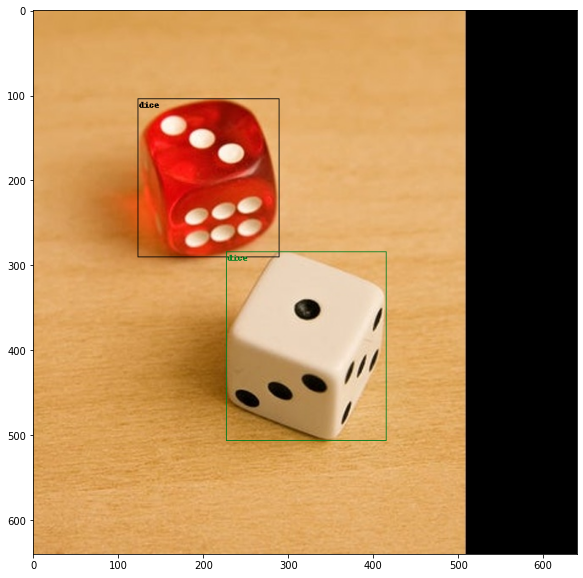

In [1]:
from torch.utils.data import Dataset, DataLoader, default_collate
from torchvision.io import read_image, ImageReadMode
from torchvision.transforms.functional import convert_image_dtype
from torchvision.utils import draw_bounding_boxes
from matplotlib import pyplot as plt
import torch
import numpy as np
import pandas as pd
import os

DATA_ROOT = "./dataset"

# Define a class to handle data loading from disk
class ODDataset(Dataset):
    def __init__(self, data_root, mode="train"):
        '''
        data_root: path to the root directory of the dataset
        mode: ["train"(default)/"val"/"test"] available modes/splits of the dataset
        '''
        super().__init__()
        
        assert mode in ["train", "val", "test"]

        self.mode = mode
        self.root = data_root
        
        # Build dataset
        self._build_db()
        
        # Define dataset nomenclanture
        self.categories = {
            "battery": 0,
            "dice": 1,
            "toycar": 2,
            "candle": 3,
            "highlighter": 4,
            "spoon": 5
        }
        
    @property
    def reverse_categories(self) -> dict:
        '''
        Returns a category id to category name mapping as a dict
        '''
        return {v:k for k, v in self.categories.items()}
        
        
    def _build_db(self) -> None:
        '''
        Collect a database of all available samples
        '''
        self.db = pd.read_csv(
            os.path.join(self.root, f"{self.mode}_test.txt"),
            header=None
        ).values.flatten().tolist()
        
    def _parse_sample(self, sample: str) -> tuple:
        '''
        Read image and object detection label data 
        '''
        
        im_file = os.path.join(self.root, self.mode, "images", sample)
        assert os.path.exists(im_file)
        
        label_file = os.path.join(self.root, self.mode, "labels", sample.replace(".jpg", ".txt"))
        assert os.path.exists(label_file)
        
        # read image from disk and convert to [0,1] float32
        im = convert_image_dtype(read_image(im_file, mode=ImageReadMode.RGB), dtype=torch.float32)
        
        # read label in KITTI format and parse labels and bboxes as list of dict {"labels", "boxes"}
        # boxes in xyxy format (left, top, right, bottom)
        labels_kitti = pd.read_csv(label_file, sep=" ", header=None).values
        labels = default_collate([{
            "boxes": torch.from_numpy(row_record[4:8].astype(np.int64)),
            "labels": self.categories[row_record[0]]
        } for row_record in labels_kitti ])
        
        return im, labels
    
    def __getitem__(self, index) -> tuple:
        '''
        Retrieve a specific sample from the dataset
        '''
        sample = self.db[index]
        return self._parse_sample(sample)
    
    def __len__(self):
        '''
        Returns the total number of samples in the dataset
        '''
        return len(self.db)

# Initialize a dataset instance for testing purposes
dset = ODDataset(DATA_ROOT, mode="train")

# Visualize sample #0
sample = dset[0]

# Draw bounding boxes on image
drawn_image = draw_bounding_boxes(
    image=convert_image_dtype(sample[0], torch.uint8),
    boxes=sample[1]["boxes"],
    labels=[dset.reverse_categories[int(cat_id)] for cat_id in sample[1]["labels"]],
)
plt.rcParams["figure.figsize"] = (10,10)
plt.imshow(drawn_image.permute(1,2,0).numpy())

In [2]:
from typing import List, Tuple

train_dset = ODDataset(DATA_ROOT, mode="train")
val_dset = ODDataset(DATA_ROOT,mode="val")
test_dset = ODDataset(DATA_ROOT, mode="test")

# Define an appropriate DataLoader

# Specify a custom collate function to perform manual batching
def custom_collate(samples: List[Tuple[torch.Tensor, dict]]) -> Tuple[List[torch.Tensor], List[dict]]:
    '''
    samples: a list of tuples. Each tuple has a RGB image as a torch.Tensor and a dict with the following:
                    -- "boxes" : Nx4 boxes found in each image
                    -- "labels": N, categories of each object found
    
    Returns (tuple):
        --  List of images (variable sizes allowed) of type torch.Tensor
        --  List of dict with the following data:
                -- "boxes" : Nx4 boxes found in each image
                -- "labels": N, categories of each object found
    '''
    images = [s[0] for s in samples]
    labels = [s[1] for s in samples]
    
    return images, labels

# Define dataloaders for train/val/test splits
train_dloader = DataLoader(train_dset, batch_size=8, shuffle=True, collate_fn=custom_collate, num_workers=8, prefetch_factor=2)
val_dloader = DataLoader(val_dset, batch_size=8, shuffle=False, collate_fn=custom_collate, num_workers=8, prefetch_factor=2)
test_dloader = DataLoader(test_dset, batch_size=8, shuffle=False, collate_fn=custom_collate, num_workers=8, prefetch_factor=2)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Step 2

#### Define an OD model - Two stage Detector Faster-RCNN

In [3]:
import pytorch_lightning as pl
from typing import Optional
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn

# Define a Faster RCNN model
class FasterRCNNModel(pl.LightningModule):
    def __init__(self, num_classes):
        '''
        num_classes: Number of target classes in the dataset
        '''
        super().__init__()
        
        # Use a pretrained backbone with "new" ROI head
        self.model = fasterrcnn_resnet50_fpn(
            pretrained=False, 
            progress=False, 
            num_classes=num_classes, 
            pretrained_backbone=True, 
            trainable_backbone_layers=True)
        self.training_phase: Optional[int] = None

        self.save_hyperparameters()
        
        
    def forward(self, x: List[torch.Tensor]) -> List[dict]:
        '''
        x: List of images (any size)
        
        Returns:
        - List of dicts with keys (one dict per input image):
            -- "boxes" : Nx4 boxes found in each image
            -- "labels" : N, categories of each object found
            -- "scores" : N, prediction scores for each object found
        '''
        assert not self.training, "Use forward only for inference!"
        
        return self.model(x)
    
        
    def training_step(self, batch, batch_idx):
        '''
        Training logic
        '''
        images, labels = batch
        
        # When in train mode FRCNN returns a dict of losses
        #    -- loss_objectness (RPN)
        #    -- loss_rpn_box_reg (RPN)
        #    -- loss_classifier (ROI Heads)
        #    -- loss_box_reg (ROI Heads)
        losses = self.model(images, labels) 
    
        # Reduce by sum and return the appropriate composite loss function according to the current training phase
        assert self.training_phase is not None
        if self.training_phase % 2 == 0:
            # Phase 0 or 2
            self.log("loss/objectness", losses["loss_objectness"], batch_size=len(images), on_epoch=True, on_step=False)
            self.log("loss/rpn_box_reg", losses["loss_rpn_box_reg"], batch_size=len(images), on_epoch=True, on_step=False)
            return sum([losses["loss_objectness"], losses["loss_rpn_box_reg"]])
        else:
            # Phase 1 or 3 
            self.log("loss/classifier", losses["loss_classifier"], batch_size=len(images), on_epoch=True, on_step=False)
            self.log("loss/box_reg", losses["loss_box_reg"], batch_size=len(images), on_epoch=True, on_step=False)
            return sum([losses["loss_classifier"], losses["loss_box_reg"]])
        
    
    def configure_optimizers(self):
        '''
        Define optimizer and trainable parameters according to current training phase
        '''
        print(f"Configuring optimizers for training phase : {self.training_phase} / 3")
        assert self.training_phase is not None, "Set training phase first!"
        if self.training_phase == 0:
            # Train only RPN + backbone
            return torch.optim.Adam(
                params=[
                    {"params": self.model.backbone.parameters()},
                    {"params":self.model.rpn.parameters()}
                ],
                lr = 1e-4
            )
        elif self.training_phase == 1:
            # Train only RoiHeads + backbone
            return torch.optim.Adam(
                params=[
                    {"params": self.model.backbone.parameters()},
                    {"params":self.model.roi_heads.parameters()}
                ],
                lr = 1e-4
            )
        elif self.training_phase == 2:
            # Train only RPN 
            return torch.optim.Adam(
                params=self.model.rpn.parameters(), #type: ignore
                lr = 1e-4
            )
        elif self.training_phase == 3:
            # Train only RoiHeads 
            return torch.optim.Adam(
                params=self.model.roi_heads.parameters(), #type: ignore
                lr = 1e-4
            )
        raise AssertionError("Invalid training phase")

#### Fine tune on new data!

In [ ]:
%tensorboard --logdir=.
# Reload manually to update results (at first hit reload after 1st epoch is done)

In [ ]:
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from copy import deepcopy

# Initialize a Faster RCNN model
model = FasterRCNNModel(num_classes=6)

# Train in 4 phases as described in the original paper

# Phase 0
model.training_phase = 0

# Save initial weights of the backbone CNN
p0_backbone_state_dict = deepcopy(model.model.backbone.state_dict())

trainer = pl.Trainer(
    accelerator="gpu", 
    devices=1,
    max_epochs=10,
    default_root_dir="frcnn_p0"
)
trainer.fit(model, train_dataloaders=train_dloader)


# Phase 1

# Restore initial weights of the backbone CNN
model.model.backbone.load_state_dict(p0_backbone_state_dict)

model.training_phase = 1
trainer = pl.Trainer(
    accelerator="gpu", 
    devices=1,
    max_epochs=10,
    default_root_dir="frcnn_p1",
    check_val_every_n_epoch=5
)
trainer.fit(model, train_dataloaders=train_dloader, val_dataloaders=val_dloader)

# Phase 2
model.training_phase = 2
trainer = pl.Trainer(
    accelerator="gpu", 
    devices=1,
    max_epochs=10,
    default_root_dir="frcnn_p2"
)
trainer.fit(model, train_dataloaders=train_dloader)

# Phase 3

model.training_phase = 3
trainer = pl.Trainer(
    accelerator="gpu", 
    devices=1,
    min_epochs=10,
    max_epochs=100,
    default_root_dir="frcnn_p3",
    check_val_every_n_epoch=2,
)
trainer.fit(model, train_dataloaders=train_dloader, val_dataloaders=val_dloader)

# Step 3

# One stage Detector (RetinaNet)

Wrapping a RetinaNet model with a ResNet-50-FPN backbone in pytorch lightning and training it in a new task 

In [4]:
from torchvision.models.detection import retinanet_resnet50_fpn

class retinanet(pl.LightningModule):
    def __init__(self, num_classes):
        '''
        num_classes: Number of target classes in the dataset
        '''
        super().__init__()
        
        self.model = retinanet_resnet50_fpn(
            pretrained=False, 
            progress=False, 
            num_classes=num_classes, 
            pretrained_backbone=True, 
            trainable_backbone_layers=True)
        self.lr = 1e-3
        
        
    def forward(self, x: List[torch.Tensor]) -> List[dict]:
        '''
        x: List of images (any size)
        
        Returns:
        - List of dicts with keys (one dict per input image):
            -- "boxes" : Nx4 boxes found in each image
            -- "labels" : N, categories of each object found
            -- "scores" : N, prediction scores for each object found
        '''
        assert not self.training, "Use forward only for inference!"
        
        return self.model(x)
    
        
    def training_step(self, batch, batch_idx):
        '''
        Training logic
        '''
        images, labels = batch
        
        out = self.model(images, labels) 
        loss = out['bbox_regression'] + out['classification']
        self.log('train loss', loss.item())

        return loss

    def validation_step(self, batch, batch_idx):
        # OPTIONAL
        images, labels = batch
        self.train()
        
        with torch.no_grad():
          out = self.model(images, labels) 
          loss = out['bbox_regression'] + out['classification']
          self.log('val loss', loss.item())
        return loss      
    
    def configure_optimizers(self):
        '''
        Define optimizer and trainable parameters 
        '''
        opt =  torch.optim.SGD(self.parameters(), self.lr, 0.9)
        sched = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(opt, 37*3) ## changed
        return [opt], [{                                                       ## changed
                'scheduler': sched,                                            ## changed
                'interval': 'step', # The unit of the scheduler's step size    ## changed
            }]
 

In [6]:
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from copy import deepcopy

# Initialize a retinanet model
model = retinanet(num_classes=7)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and will be removed in 0.15, please use 'weights_backbone' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight

In [7]:
#Unfreeze model
for p in model.parameters():
  p.requires_grad = True

In [8]:
#Train model
trainer = pl.Trainer(
    accelerator="gpu", 
    devices=1,
    max_epochs=20,
    default_root_dir="retinanet"
)
trainer.fit(model, train_dataloaders=train_dloader, val_dataloaders=val_dloader)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type      | Params
------------------------------------
0 | model | RetinaNet | 32.3 M
------------------------------------
32.3 M    Trainable params
0         Non-trainable params
32.3 M    Total params
129.090   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/data.py:73: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 3. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  "Trying to infer the `batch_size` from an ambiguous collection. The batch size we"


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [9]:
#Save model
torch.save(model.state_dict(), '/content/retinanet2.pth')

# Step 4

# Visualize and Evaluate models

Calculate mAP of the two models on the test set and visualize a random batch (size 8) of the test set for the ground truth and the two model predictions.

The calculation for mAP for the whole set is not possible because of RAM so we compute the metric for two random batches instead!



In [ ]:
#Load one stage model in new session for step 4

model = retinanet(num_classes=7)
model.load_state_dict(torch.load('/content/retinanet2.pth'))
model.eval()

In [ ]:
# Load two-stage model from checkpoint

pretrained_model = FasterRCNNModel.load_from_checkpoint('/content/faster_rcnn_fixed.ckpt')
pretrained_model.eval()

In [7]:
iterator = iter(test_dloader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [8]:
#Calculate metrics for two batches instead of the whole test set 

from torchmetrics.detection.mean_ap import MeanAveragePrecision

batch_1 = next(iterator)
batch_2 = next(iterator)

mAP_retinanet_1 = MeanAveragePrecision()
mAP_retinanet_2 = MeanAveragePrecision()
mAP_faster_rcnn_1 = MeanAveragePrecision()
mAP_faster_rcnn_2 = MeanAveragePrecision()

X_1 = batch_1[0]
X_2 = batch_2[0]
y_1 = batch_1[1]
y_2 = batch_2[1]

preds_one_stage_1 = model(X_1)
preds_one_stage_2 = model(X_2)
preds_two_stage_1 = pretrained_model(X_1)
preds_two_stage_2 = pretrained_model(X_2)

mAP_retinanet_1.update(preds_one_stage_1, y_1)
mAP_retinanet_2.update(preds_one_stage_2, y_2)

mAP_faster_rcnn_1.update(preds_two_stage_1, y_1)
mAP_faster_rcnn_2.update(preds_two_stage_2, y_2)



In [9]:
mAP_retinanet_1.compute()

{'map': tensor(0.6590),
 'map_50': tensor(1.),
 'map_75': tensor(0.8191),
 'map_large': tensor(-1.),
 'map_medium': tensor(0.6590),
 'map_per_class': tensor(-1.),
 'map_small': tensor(-1.),
 'mar_1': tensor(0.5000),
 'mar_10': tensor(0.7273),
 'mar_100': tensor(0.7273),
 'mar_100_per_class': tensor(-1.),
 'mar_large': tensor(-1.),
 'mar_medium': tensor(0.7273),
 'mar_small': tensor(-1.)}

In [10]:
mAP_retinanet_2.compute()


{'map': tensor(0.7191),
 'map_50': tensor(1.),
 'map_75': tensor(0.8696),
 'map_large': tensor(0.8000),
 'map_medium': tensor(0.6892),
 'map_per_class': tensor(-1.),
 'map_small': tensor(-1.),
 'mar_1': tensor(0.4917),
 'mar_10': tensor(0.7500),
 'mar_100': tensor(0.7500),
 'mar_100_per_class': tensor(-1.),
 'mar_large': tensor(0.8000),
 'mar_medium': tensor(0.7400),
 'mar_small': tensor(-1.)}

In [11]:
mAP_faster_rcnn_1.compute()

{'map': tensor(0.8043),
 'map_50': tensor(1.),
 'map_75': tensor(1.),
 'map_large': tensor(-1.),
 'map_medium': tensor(0.8043),
 'map_per_class': tensor(-1.),
 'map_small': tensor(-1.),
 'mar_1': tensor(0.6091),
 'mar_10': tensor(0.8273),
 'mar_100': tensor(0.8273),
 'mar_100_per_class': tensor(-1.),
 'mar_large': tensor(-1.),
 'mar_medium': tensor(0.8273),
 'mar_small': tensor(-1.)}

In [12]:
mAP_faster_rcnn_2.compute()

{'map': tensor(0.7807),
 'map_50': tensor(1.),
 'map_75': tensor(1.),
 'map_large': tensor(0.7505),
 'map_medium': tensor(0.7371),
 'map_per_class': tensor(-1.),
 'map_small': tensor(-1.),
 'mar_1': tensor(0.5667),
 'mar_10': tensor(0.8250),
 'mar_100': tensor(0.8250),
 'mar_100_per_class': tensor(-1.),
 'mar_large': tensor(0.7500),
 'mar_medium': tensor(0.8400),
 'mar_small': tensor(-1.)}

In [ ]:
#Calculate Mean Average Precision for Test Set (Two-Stage - Faster RCNN)

#This calculation crashes because of available RAM

from torchmetrics.detection.mean_ap import MeanAveragePrecision

metric = MeanAveragePrecision()
for batch in test_dloader:
  X = batch[0]
  y = batch[1]
  preds_two_stage = pretrained_model(X)
  metric.update(preds_two_stage, y)


metric.compute()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
#Calculate Mean Average Precision for Test Set (One-Stage - RetinaNet)

#This calculation crashes because of available RAM


metric = MeanAveragePrecision()
for batch in test_dloader:
  X = batch[0]
  y = batch[1]
  preds_one_stage = model(X)
  metric.update(preds_one_stage, y)


metric.compute()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [16]:
# Visualize targets and predictions of random batch of size 8

batch = next(iterator)

X = batch[0]
y = batch[1]

#Predictions for Faster RCNN
preds_two_stage = pretrained_model(X)

#Predictions for RetinaNet
preds_one_stage = model(X)

In [14]:
#Functions to visualize results

def draw_true_label(i):
  return draw_bounding_boxes(
    image=convert_image_dtype(X[i], torch.uint8),
    boxes=y[i]["boxes"],
    labels=[dset.reverse_categories[int(cat_id)] for cat_id in y[i]["labels"]],
)

def draw_predicted_label_two_stage(i):
  return draw_bounding_boxes(
    image=convert_image_dtype(X[i], torch.uint8),
    boxes=preds_two_stage[i]["boxes"],
    labels=[dset.reverse_categories[int(cat_id)] for cat_id in preds_two_stage[i]["labels"]],
)
  
def draw_predicted_label_one_stage(i):
  return draw_bounding_boxes(
    image=convert_image_dtype(X[i], torch.uint8),
    boxes=preds_one_stage[i]["boxes"],
    labels=[dset.reverse_categories[int(cat_id)] for cat_id in preds_one_stage[i]["labels"]],
)
  
def visualize_results(i):
  fig = plt.figure(figsize=(30, 10))
  rows = 1  
  columns = 3
  fig.add_subplot(rows, columns, 1)
  plt.axis('off')
  plt.imshow(draw_true_label(i).permute(1,2,0).numpy())
  plt.title("True")
  fig.add_subplot(rows, columns, 2)
  plt.axis('off')
  plt.imshow(draw_predicted_label_two_stage(i).permute(1,2,0).numpy())
  plt.title("Predicted - Faster RCNN")
  fig.add_subplot(rows, columns, 3)
  plt.axis('off')
  plt.imshow(draw_predicted_label_one_stage(i).permute(1,2,0).numpy())
  plt.title("Predicted - RetinaNet")
  

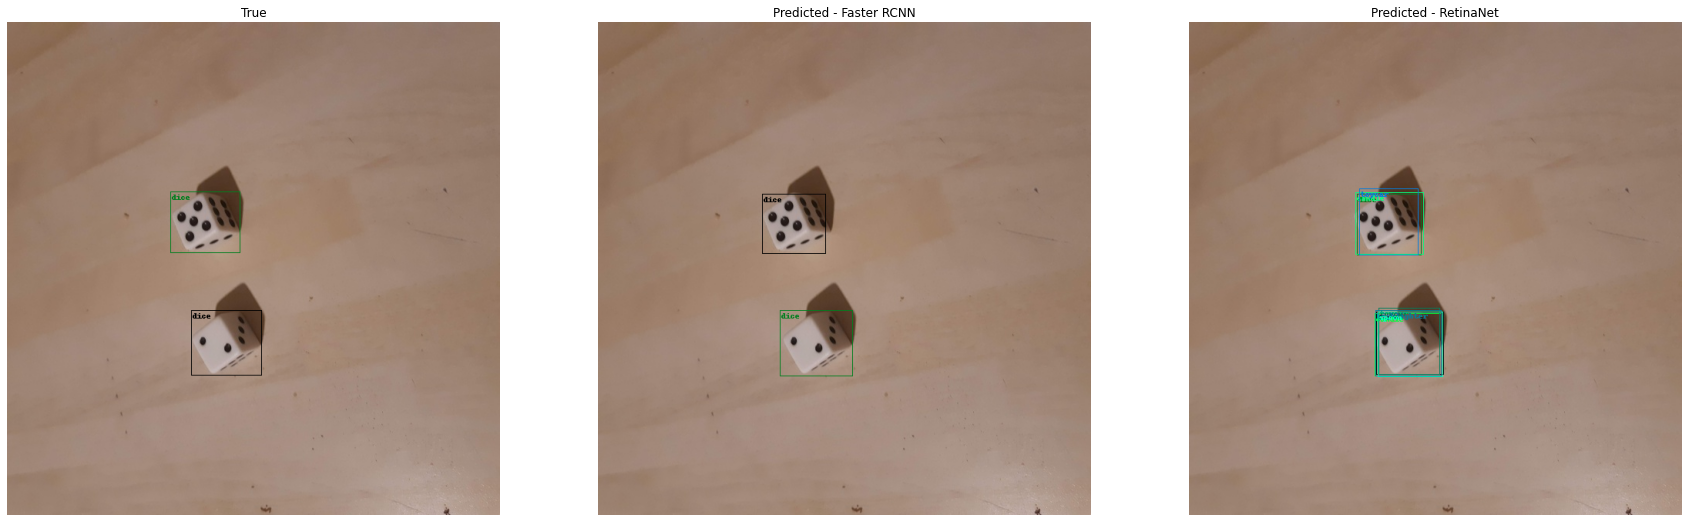

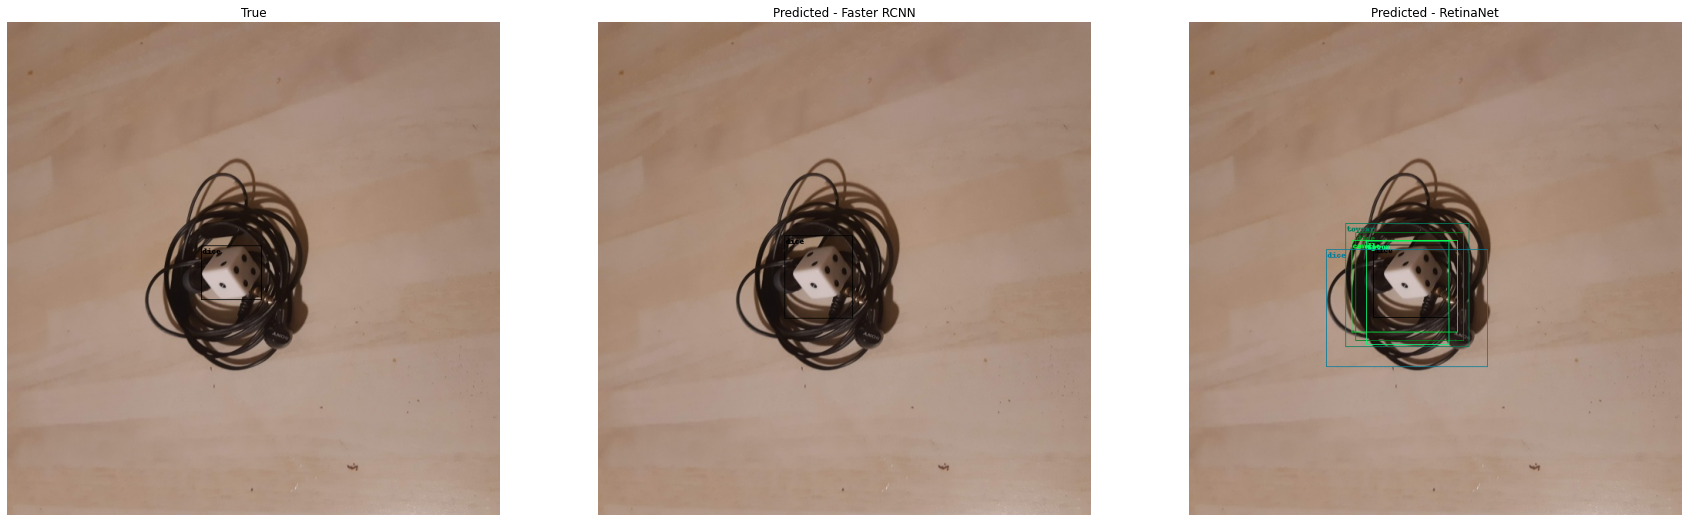

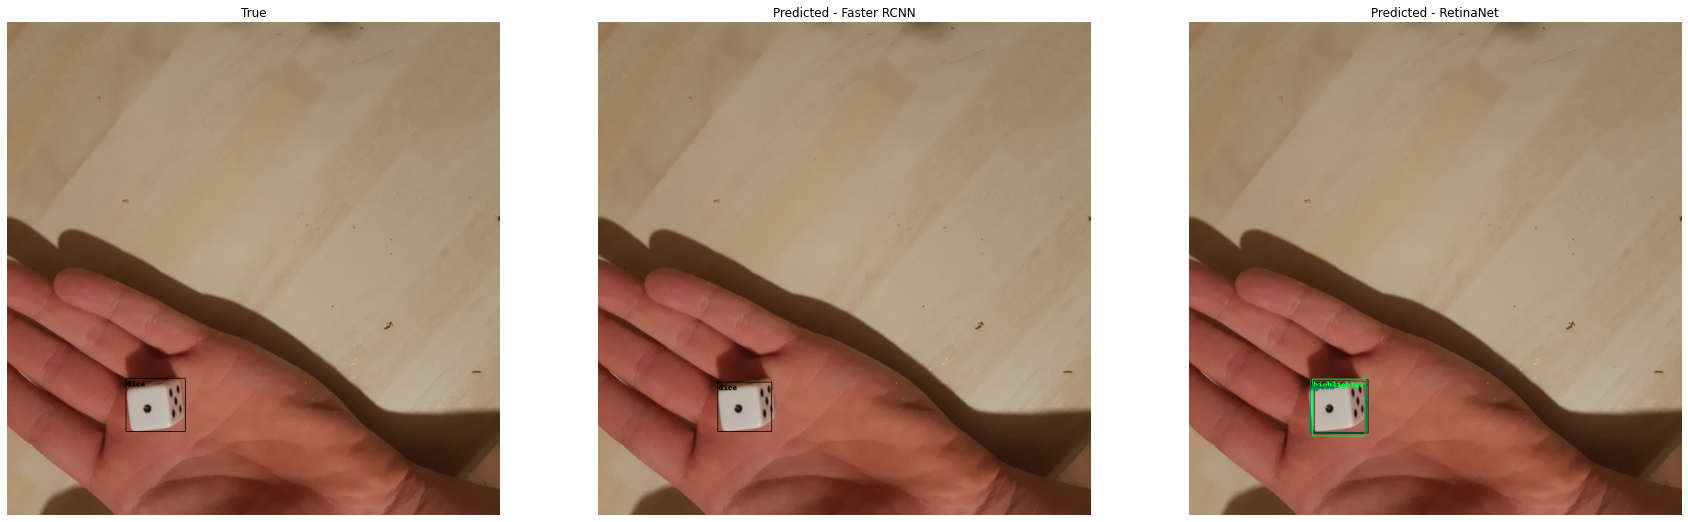

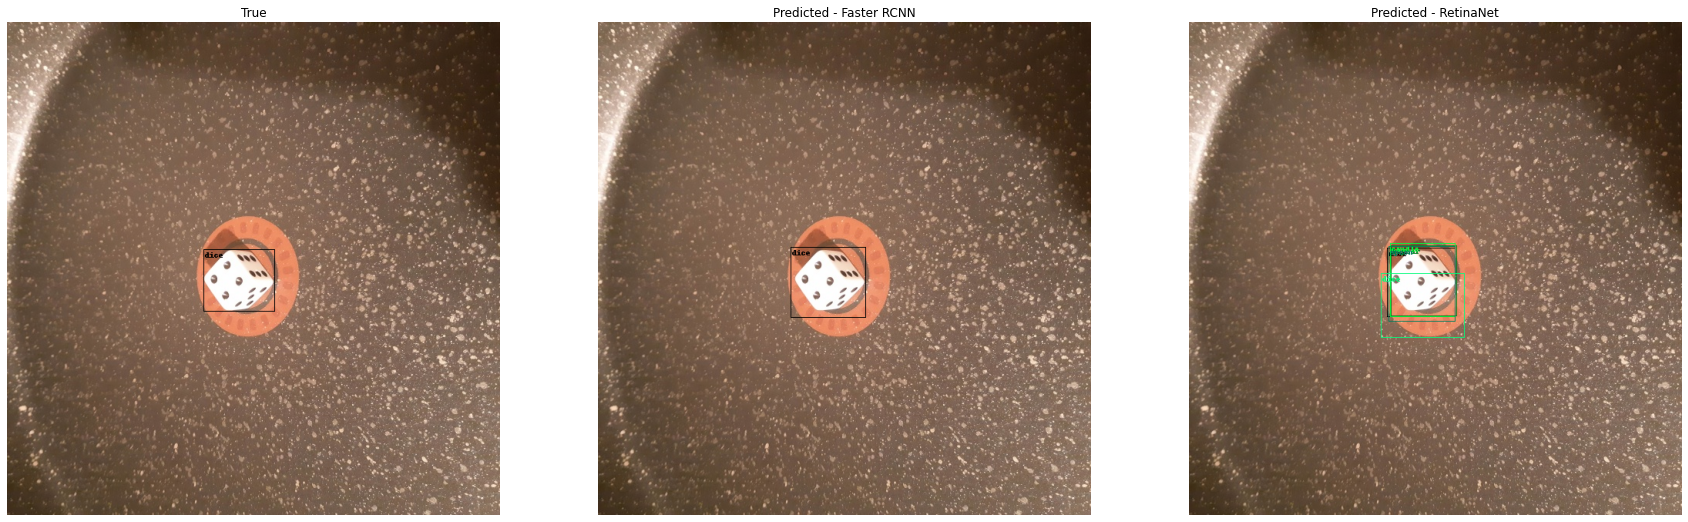

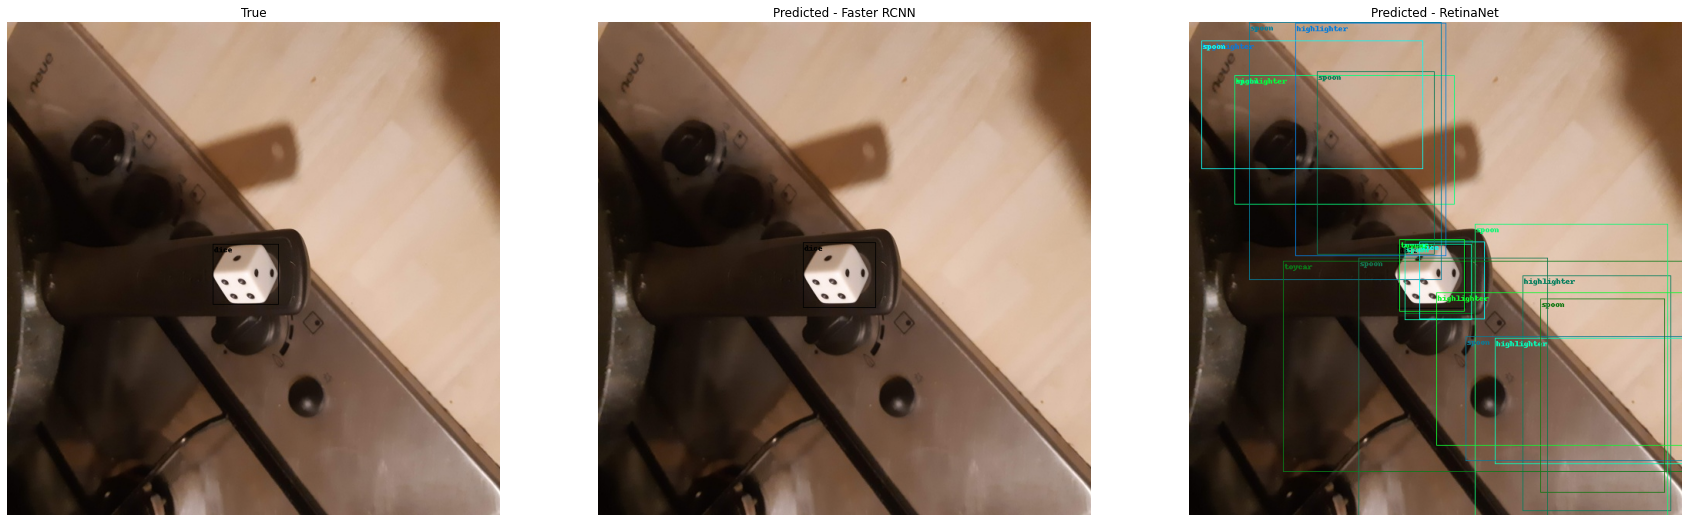

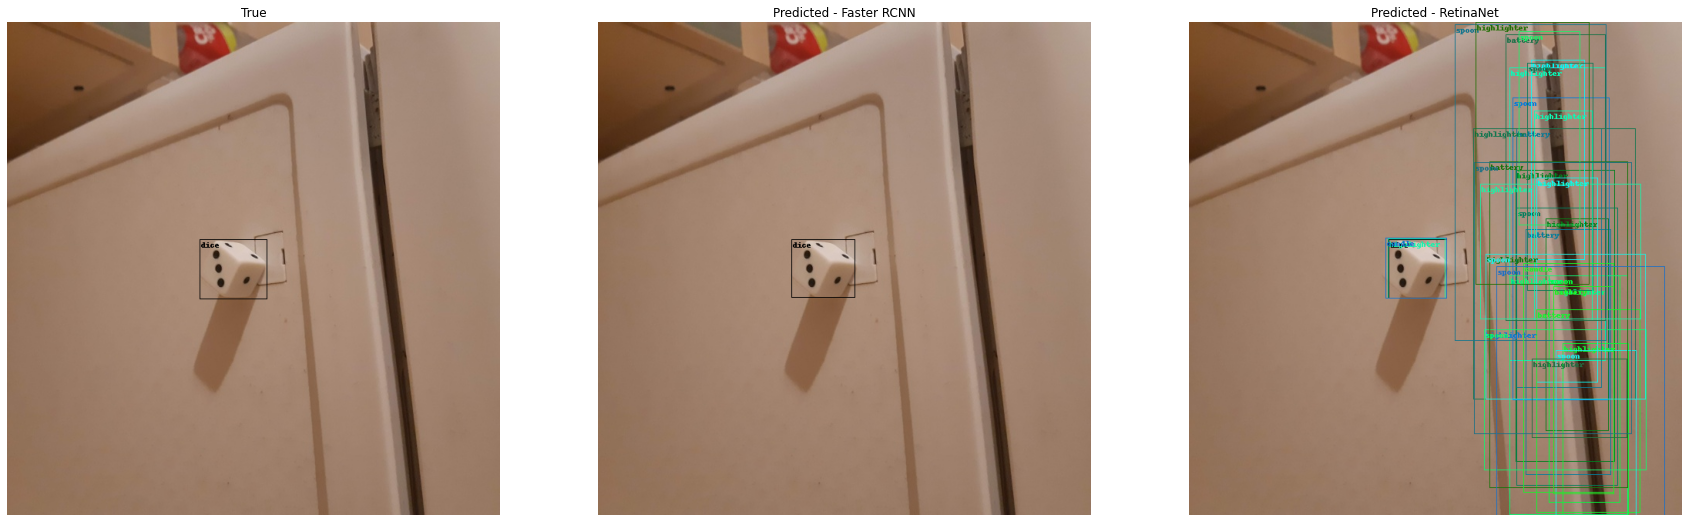

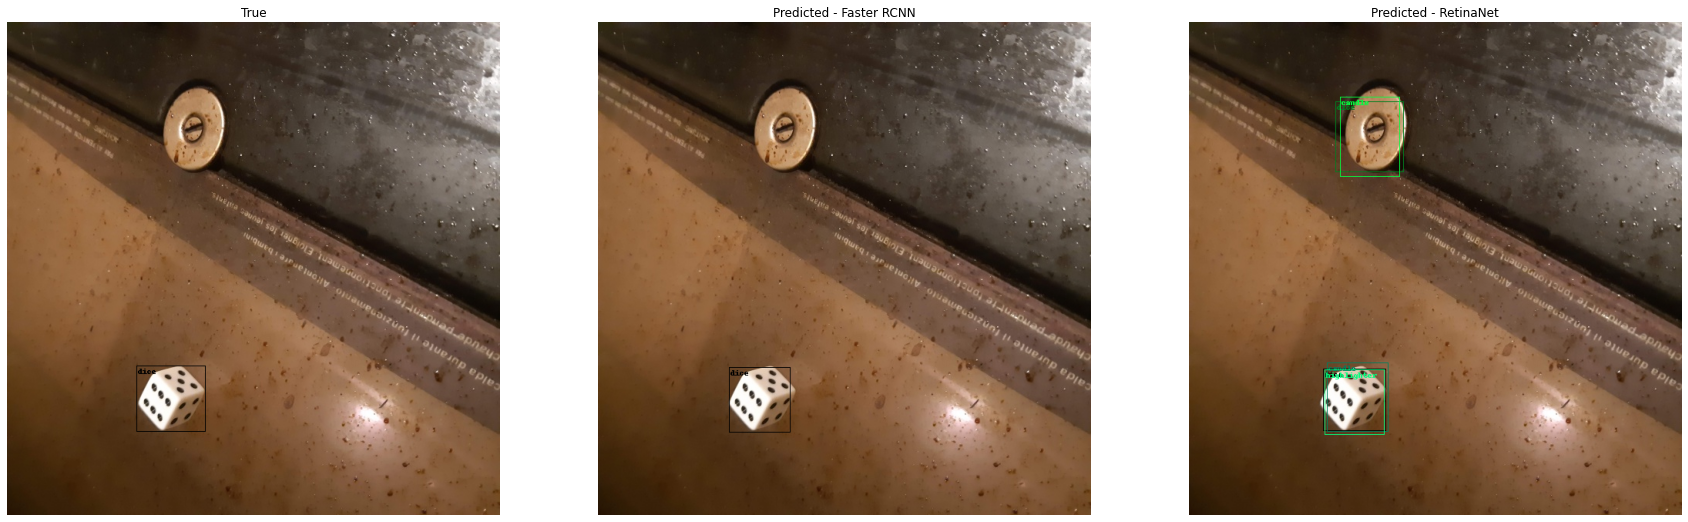

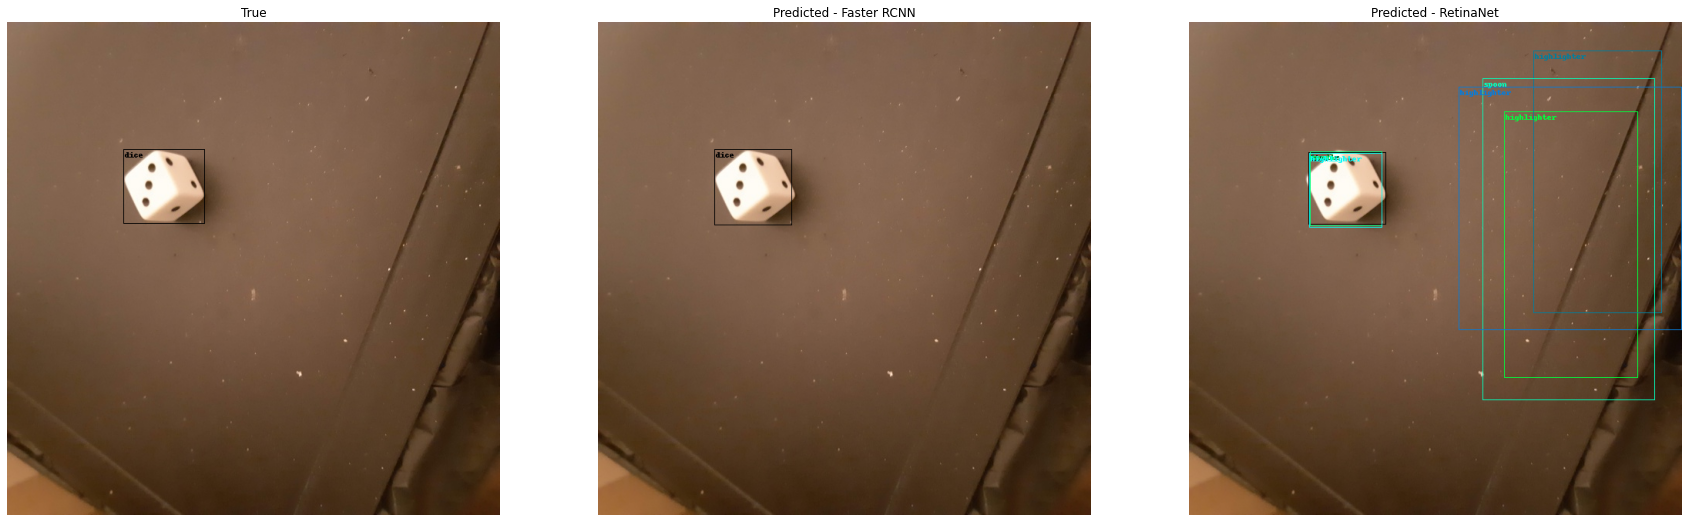

In [17]:
#Visualize Results for one batch of 8 images

for i in range(8):  
  visualize_results(i)

# Commenting on Results

From the calculation of the mean Average Precision and the visualization of a random batch we can see that the Faster RCNN model that was given to us outperforms the RetinaNet model that was trained in the dataset. More specifically, the RetinaNet model seems to produce many bounding boxes around each object and also identify more wrong objects in the image. The model should probably be trained for more epochs and apply Non Maximum Suppression (NMS) in order to discard some of the very dense proposals that we see in the visualization

# Part 2 - Questions

## Question 1
The first training step of the Faster-RCNN model is training the Region Proposal Network independently for the Region Proposal Task. This part of the Faster-RCNN architecture does not differentiate betweetn the different categories of elements we are trying to detect with the Object Detection algorithm but rather tries to calculate the best bounding box and the probability that one object (does not matter which) is inside that bounding box.
The mAP metric is the mean of all Average Precisions of the different categories we are trying to detect in the OD task. The Average Precision of a certain category is the average of the precision values of the Precison/Recall diagram for different confidence thresholds. Thus the mAP metric does not apply for the Region Proposal Network part of the Faster-RCNN architecture which is trained in training steps 1 and 3 and should bot be used as an early stopping criterion. Another early stopping criterion that can be used instead is the Average Precision or the accuracy of the object proposal.


## Question 2
The bounding boxes are trained and selected through the Bounding Box Regression head of the Faster RCNN network. So in order to achieve better localization of the bounding boxes, we possibly to continue training the model more. In addition, since the loss function of the Faster RCNN network consists of 4 different losses, which depending on the part of the network are summed in pairs. For the RPN network is the sum of the object proposal classification scores (binary for whether there is an object or not) and the regression coefficients of the boxes, whereas for the Fast RCNN part of the network the loss is the sum of loss of the object classification (now it is for every different caregory) and the loss of BB regression. A solution for better localization could be to assign a bigger weight to the total loss of the network to the regression losses so that it will force the network to learn a better mapping for the coordinates for the bounding boxes 


## Question 3
The Object Detection algorithms like Faster RCNN first resize the input image into a standard size. For a 4K image that shows 100meters of a highway, chances are that cars will only correspond to a few pixels of the image once the image is resized. The corresponding anchors to the output feature map will mostly be discarded because the Interesection over Union (IoU) with the groundtruth boxes will be very small and thus we will have few positive examples

## Question 4
In an image from a concert crowd it is very possible that most of the image will have people depcited in it. This means that the 'groundtruth' image will have a lot of positive instances (in this case, people). However, when the RPN part of the Faster RCNN network produces proposals for the image by placing anchors, these are very dense and overlap each other. The Non-Maximum Suppression step of the architecture keeps only the proposals with the highest probability out of the ones that overlap each other. So in the case of an image with many instances of positive example, possibly overlapping each other, the NMS is problematic since it will disregard many positive examples all together. That is why there are other techniques that can be used instead, like the soft-NMS or the NMS networks.

